# Finding the most popular restaurants in New York - Capstone Project

First, all the necessary packages required for this project will be installed and imported.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#import beautiful soup
from urllib.request import urlopen
from bs4 import BeautifulSoup


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

# Finding geo location data for New York

We will use geolocator to get longitude and latitude for New York

In [2]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


# Pulling data from Foursquare

Entering information to access Foursqueare API

In [3]:
CLIENT_ID = 'A33SYNZ1C5TTQ5154JQ4KNMJCYY2O0DLOIZWEWD3HQW2Q43R' # your Foursquare ID
CLIENT_SECRET = 'YJV0YXCKMIHCQ1WVNOBYOCEGJGI1SRWSCX4M13G05QI30OTY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: A33SYNZ1C5TTQ5154JQ4KNMJCYY2O0DLOIZWEWD3HQW2Q43R
CLIENT_SECRET:YJV0YXCKMIHCQ1WVNOBYOCEGJGI1SRWSCX4M13G05QI30OTY


Creating URL to make request to the Foursquare API 

In [4]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=A33SYNZ1C5TTQ5154JQ4KNMJCYY2O0DLOIZWEWD3HQW2Q43R&client_secret=YJV0YXCKMIHCQ1WVNOBYOCEGJGI1SRWSCX4M13G05QI30OTY&v=20180605&ll=40.7127281,-74.0060152&radius=500&limit=100'

Pulling the JSON for the URL venues

In [5]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f0b611464a5d5276001e3a3'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Downtown Manhattan',
  'headerFullLocation': 'Downtown Manhattan, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 105,
  'suggestedBounds': {'ne': {'lat': 40.7172281045, 'lng': -74.00008952063419},
   'sw': {'lat': 40.7082280955, 'lng': -74.0119408793658}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '57f0689d498e7d49d9189369',
       'name': 'The Bar Room at Temple Court',
       'location': {'address': '123 Nassau St',
        'lat': 40.7114477287544,
        'lng': -74.00680157032005,
        'labe

Now we start pulling the data from Foursquare into a dataframe so we can manipulate and use it.

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802
1,Alba Dry Cleaner & Tailor,4c606c3e1e5cd13ad1a1a1ed,Laundry Service,40.711434,-74.006272
2,"The Beekman, A Thompson Hotel",56d8c0f8498edb854f926e6a,Hotel,40.711173,-74.006702
3,Gibney Dance Center Downtown,53373f26498e940581c90985,Dance Studio,40.713923,-74.005661
4,City Hall Park,3fd66200f964a520d8f11ee3,Park,40.712415,-74.006724
5,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395
6,The Class by Taryn Toomey,58a253c830ecc66c9e5b40a0,Gym / Fitness Center,40.712753,-74.008734
7,CrossFit 212 TriBeCa,52001eed498e9ac16ca5e20b,Gym,40.714537,-74.005999
8,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660
9,Takahachi Bakery,4c154c9a77cea593c401d260,Bakery,40.713653,-74.008804


# 

In [8]:
#fix the column names so they look relatively normal

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,id,categories,lat,lng
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802
1,Alba Dry Cleaner & Tailor,4c606c3e1e5cd13ad1a1a1ed,Laundry Service,40.711434,-74.006272
2,"The Beekman, A Thompson Hotel",56d8c0f8498edb854f926e6a,Hotel,40.711173,-74.006702
3,Gibney Dance Center Downtown,53373f26498e940581c90985,Dance Studio,40.713923,-74.005661
4,City Hall Park,3fd66200f964a520d8f11ee3,Park,40.712415,-74.006724
5,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395
6,The Class by Taryn Toomey,58a253c830ecc66c9e5b40a0,Gym / Fitness Center,40.712753,-74.008734
7,CrossFit 212 TriBeCa,52001eed498e9ac16ca5e20b,Gym,40.714537,-74.005999
8,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660
9,Takahachi Bakery,4c154c9a77cea593c401d260,Bakery,40.713653,-74.008804


In [9]:
# find a list of unique categories from the API so we can see what may or may not fit for restaurants

nearby_venues['categories'].unique()

array(['Hotel Bar', 'Laundry Service', 'Hotel', 'Dance Studio', 'Park',
       'Coffee Shop', 'Gym / Fitness Center', 'Gym', 'French Restaurant',
       'Bakery', 'Sandwich Place', 'Indian Restaurant', 'Taco Place',
       'Yoga Studio', 'Monument / Landmark', 'Building', 'Boxing Gym',
       'Burrito Place', 'Pizza Place', 'Italian Restaurant',
       'Cuban Restaurant', 'Falafel Restaurant', 'Burger Joint',
       'Furniture / Home Store', 'Café', 'Martial Arts Dojo', 'Spa',
       'Antique Shop', 'Plaza', 'Strip Club', 'Fast Food Restaurant',
       'Sporting Goods Shop', 'Baby Store', 'Juice Bar', 'Bookstore',
       'Cocktail Bar', "Women's Store", 'American Restaurant',
       'Coworking Space', 'Japanese Restaurant',
       'Molecular Gastronomy Restaurant', 'Nail Salon', 'Comic Shop',
       'Sushi Restaurant', 'Wine Shop', 'Vegetarian / Vegan Restaurant',
       'Electronics Store', 'Bubble Tea Shop', 'Greek Restaurant',
       'Breakfast Spot', 'Shopping Mall', 'Theater', 'Ba

In [10]:
# creating a list of categorie to remove from our dataframe because they are not restaurants
# I am sure there is a function that can be written to do this at scale but since it was a small list, I did it manually

removal_list = ['Gym / Fitness Center', 'Bakery', 'Park', "Women's Store", 'Sporting Goods Shop', 'Dog Run', 'Gaming Cafe',
               'Optical Shop', 'Yoga Studio', 'Pet Store', 'Shoe Repair', 'Jewelry Store', 'Record Shop', 'Juice Bar', 
               'Cosmetics Shop', 'Business Service', 'Salon / Barbershop', 'Liquor Store', 'Grocery Store', 'Stationery Store',
               'Pilates Studio', 'Dessert Shop', 'Bookstore', 'Concert Hall', 'Video Game Store', 'Pharmacy', 'Mobile Phone Shop',
               'Deli / Bodega']

nearby_venues2 = nearby_venues.copy()


#getting a clear dataframe of just restaurants
nearby_venues2 = nearby_venues2[~nearby_venues2['categories'].isin(removal_list)]
nearby_venues2

,name,id,categories,lat,lng
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802
1,Alba Dry Cleaner & Tailor,4c606c3e1e5cd13ad1a1a1ed,Laundry Service,40.711434,-74.006272
2,"The Beekman, A Thompson Hotel",56d8c0f8498edb854f926e6a,Hotel,40.711173,-74.006702
3,Gibney Dance Center Downtown,53373f26498e940581c90985,Dance Studio,40.713923,-74.005661
5,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395
7,CrossFit 212 TriBeCa,52001eed498e9ac16ca5e20b,Gym,40.714537,-74.005999
8,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660
10,Pisillo Italian Panini,528bf16711d2b7722da6b51c,Sandwich Place,40.710530,-74.007526
11,Aahar Indian Cuisine,575dea4c498e2739e43a27e2,Indian Restaurant,40.713307,-74.007994
12,Four Seasons Hotel New York Downtown,57c640ad498e74977f98372f,Hotel,40.712612,-74.009380


Now let's get a list of venue ids so we can pull likes and add to our dataframe.

In [11]:
#let's get a list of venues

venue_id_list = nearby_venues2['id'].tolist()
venue_id_list

['57f0689d498e7d49d9189369',
 '4c606c3e1e5cd13ad1a1a1ed',
 '56d8c0f8498edb854f926e6a',
 '53373f26498e940581c90985',
 '56093809498e5344ab8835a6',
 '52001eed498e9ac16ca5e20b',
 '58191674ded8f8626ed70af0',
 '528bf16711d2b7722da6b51c',
 '575dea4c498e2739e43a27e2',
 '57c640ad498e74977f98372f',
 '5d5f24ec09484500079aee00',
 '4a9442e3f964a520f92020e3',
 '534c9d7b498e1bdd443a40e1',
 '4be99814a9900f479a811540',
 '4b8dbba4f964a5201e0b33e3',
 '4ee8e058f790a9d738d62d70',
 '5c6f03f30802d4002c16884c',
 '5447e0b2498e49ee7c7b1dc0',
 '5421eb06498e1b6b9c1bfd9c',
 '4b311e89f964a520890025e3',
 '50ba9119e4b071a4bae6dc10',
 '5787b68e498efcabbebba4f8',
 '4af5d65ff964a52091fd21e3',
 '4a6e331af964a52031d41fe3',
 '588a4316326c5a4b60559f17',
 '4f4d2593e4b00b42c3f1060f',
 '4e31c3b1814d9a6fbde557c7',
 '57ad129c498e05b086594d72',
 '4b747291f964a52042dd2de3',
 '5021648ae4b0b9f6b6d566b2',
 '433b2e80f964a52036281fe3',
 '5ab51b6aa4b51b3dc096ed68',
 '5953e5314382ab0b3b808dc6',
 '4cc368704fcfbfb70a0cbe24',
 '53a7307a498e

In [12]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[192, 28, 208, 56, 156, 17, 238, 292, 53, 67, 78, 93, 120, 116, 67, 126, 76, 100, 72, 112, 403, 505, 100, 250, 12, 50, 6, 30, 42, 12, 87, 66, 52, 18, 175, 34, 39, 466, 14, 164, 62, 269, 14, 183, 40, 110, 147, 318, 90, 330, 86, 376, 84, 564, 8, 447, 23, 31, 173, 303, 327, 449, 10, 10, 422, 68, 28, 537, 404, 375, 57, 468, 58, 5, 4, 54, 68, 184, 8, 8, 111, 62, 6, 763, 94, 143, 113]


In [13]:
#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

87
87


# Data Preparation

Now let's start prepping our data for clustering. This will include combining data from different lists, creating new categorical data to be used, binning data and then encoding the data for clustering.

In [14]:
#let's make a copy of our initial dataframe just in case anything goes wrong

ny_venues = nearby_venues2.copy()
ny_venues.head()

,name,id,categories,lat,lng
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802
1,Alba Dry Cleaner & Tailor,4c606c3e1e5cd13ad1a1a1ed,Laundry Service,40.711434,-74.006272
2,"The Beekman, A Thompson Hotel",56d8c0f8498edb854f926e6a,Hotel,40.711173,-74.006702
3,Gibney Dance Center Downtown,53373f26498e940581c90985,Dance Studio,40.713923,-74.005661
5,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395


Let's combine our list of likes into our dataframe

In [15]:
# add in the list of likes

ny_venues['total likes'] = like_list
ny_venues.head()

,name,id,categories,lat,lng,total likes
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802,192
1,Alba Dry Cleaner & Tailor,4c606c3e1e5cd13ad1a1a1ed,Laundry Service,40.711434,-74.006272,28
2,"The Beekman, A Thompson Hotel",56d8c0f8498edb854f926e6a,Hotel,40.711173,-74.006702,208
3,Gibney Dance Center Downtown,53373f26498e940581c90985,Dance Studio,40.713923,-74.005661,56
5,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395,156


Let's look at our like data to set bins

In [16]:
# now let's bin total likes

print(ny_venues['total likes'].max())
print(ny_venues['total likes'].min())
print(ny_venues['total likes'].median())
print(ny_venues['total likes'].mean())

763
4
87.0
152.71264367816093


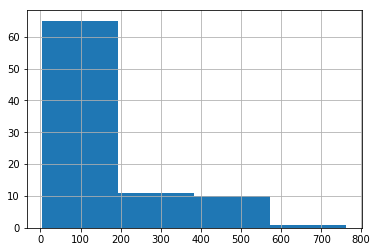

In [18]:
# let's visualize our total likes based on a histogram

import matplotlib.pyplot as plt
ny_venues['total likes'].hist(bins=4)
plt.show()

In [20]:
# what are the bins we want to use?

print(np.percentile(ny_venues['total likes'], 25))
print(np.percentile(ny_venues['total likes'], 50))
print(np.percentile(ny_venues['total likes'], 75))

39.5
87.0
200.0


In [21]:
# now we have our bin values so let's set them to the appropriate values
# less than 39, between 39 and 87, between 87 and 200, more than 200
# poor, below average, above average, great

poor = ny_venues['total likes']<=39
below_avg = ny_venues[(ny_venues['total likes']>39) & (ny_venues['total likes']<=87)]
abv_avg = ny_venues[(ny_venues['total likes']>87) & (ny_venues['total likes']<=200)]
great = ny_venues['total likes']>200

In [25]:
# let's set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']<=24:
        return 'poor'
    if s['total likes']<=45:
        return 'below avg'
    if s['total likes']<=76:
        return 'abv avg'
    if s['total likes']>76:
        return 'great'

ny_venues['total likes_cat']=ny_venues.apply(conditions, axis=1)

In [26]:
ny_venues

,name,id,categories,lat,lng,total likes,total likes_cat
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802,192,great
1,Alba Dry Cleaner & Tailor,4c606c3e1e5cd13ad1a1a1ed,Laundry Service,40.711434,-74.006272,28,below avg
2,"The Beekman, A Thompson Hotel",56d8c0f8498edb854f926e6a,Hotel,40.711173,-74.006702,208,great
3,Gibney Dance Center Downtown,53373f26498e940581c90985,Dance Studio,40.713923,-74.005661,56,abv avg
5,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395,156,great
7,CrossFit 212 TriBeCa,52001eed498e9ac16ca5e20b,Gym,40.714537,-74.005999,17,poor
8,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660,238,great
10,Pisillo Italian Panini,528bf16711d2b7722da6b51c,Sandwich Place,40.710530,-74.007526,292,great
11,Aahar Indian Cuisine,575dea4c498e2739e43a27e2,Indian Restaurant,40.713307,-74.007994,53,abv avg
12,Four Seasons Hotel New York Downtown,57c640ad498e74977f98372f,Hotel,40.712612,-74.009380,67,abv avg


In [27]:
# let's star the process for re-categorizing the categories

ny_venues['categories'].unique()

array(['Hotel Bar', 'Laundry Service', 'Hotel', 'Dance Studio',
       'Coffee Shop', 'Gym', 'French Restaurant', 'Sandwich Place',
       'Indian Restaurant', 'Taco Place', 'Monument / Landmark',
       'Building', 'Boxing Gym', 'Burrito Place', 'Pizza Place',
       'Italian Restaurant', 'Cuban Restaurant', 'Falafel Restaurant',
       'Burger Joint', 'Furniture / Home Store', 'Café',
       'Martial Arts Dojo', 'Spa', 'Antique Shop', 'Plaza', 'Strip Club',
       'Fast Food Restaurant', 'Baby Store', 'Cocktail Bar',
       'American Restaurant', 'Coworking Space', 'Japanese Restaurant',
       'Molecular Gastronomy Restaurant', 'Nail Salon', 'Comic Shop',
       'Sushi Restaurant', 'Wine Shop', 'Vegetarian / Vegan Restaurant',
       'Electronics Store', 'Bubble Tea Shop', 'Greek Restaurant',
       'Breakfast Spot', 'Shopping Mall', 'Theater', 'Bagel Shop',
       'Asian Restaurant', 'Fried Chicken Joint', 'Salad Place',
       'Poke Place', 'Japanese Curry Restaurant', 'Medical Ce

In [36]:
# let's create our new categories and create a function to apply those to our existing data


bars = ['Hotel Bar','Strip Club','Cocktail Bar','Wine Shop']
other = ['Laundry Service', 'Hotel', 'Dance Studio','Coffee Shop', 'Gym','Monument / Landmark',
         'Building', 'Boxing Gym', 'Furniture / Home Store', 'Café','Baby Store','Coworking Space','Nail Salon',
         'Comic Shop','Electronics Store', 'Bubble Tea Shop','Shopping Mall', 'Theater', 'Bagel Shop','Poke Place',
         'Medical Center','Clothing Store','Martial Arts Dojo','Spa','Shop','Antique Shop','Plaza']
fast_food = ['Sandwich Place','Taco Place','Burrito Place', 'Pizza Place','Burger Joint','Fast Food Restaurant',
             'Breakfast Spot','Bagel Shop','Fried Chicken Joint','Diner']
restaurants = ['French Restaurant','Indian Restaurant','Italian Restaurant', 'Cuban Restaurant', 'Falafel Restaurant',
               'American Restaurant','Japanese Restaurant','Sushi Restaurant','Greek Restaurant','Asian Restaurant',
               'Japanese Curry Restaurant','Korean Restaurant']
healthy_food = ['Molecular Gastronomy Restaurant','Vegetarian / Vegan Restaurant','Salad Place','Soup Place']

def conditions2(s):
    if s['categories'] in bars:
        return 'bars'
    if s['categories'] in other:
        return 'other'
    if s['categories'] in fast_food:
        return 'fast food'
    if s['categories'] in restaurants:
        return 'restaurants'
    if s['categories'] in healthy_food:
        return 'healthy food'
    

ny_venues['categories_new']=ny_venues.apply(conditions2, axis=1)

In [39]:
ny_venues

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802,192,great,bars
1,Alba Dry Cleaner & Tailor,4c606c3e1e5cd13ad1a1a1ed,Laundry Service,40.711434,-74.006272,28,below avg,other
2,"The Beekman, A Thompson Hotel",56d8c0f8498edb854f926e6a,Hotel,40.711173,-74.006702,208,great,other
3,Gibney Dance Center Downtown,53373f26498e940581c90985,Dance Studio,40.713923,-74.005661,56,abv avg,other
5,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395,156,great,other
7,CrossFit 212 TriBeCa,52001eed498e9ac16ca5e20b,Gym,40.714537,-74.005999,17,poor,other
8,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660,238,great,restaurants
10,Pisillo Italian Panini,528bf16711d2b7722da6b51c,Sandwich Place,40.710530,-74.007526,292,great,fast food
11,Aahar Indian Cuisine,575dea4c498e2739e43a27e2,Indian Restaurant,40.713307,-74.007994,53,abv avg,restaurants
12,Four Seasons Hotel New York Downtown,57c640ad498e74977f98372f,Hotel,40.712612,-74.009380,67,abv avg,other


Now let's create dummy variables for our total likes and categories so we can start clustering

In [40]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Name'] = ny_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Name,bars,fast food,healthy food,other,restaurants,abv avg,below avg,great,poor
0,The Bar Room at Temple Court,1,0,0,0,0,0,0,1,0
1,Alba Dry Cleaner & Tailor,0,0,0,1,0,0,1,0,0
2,"The Beekman, A Thompson Hotel",0,0,0,1,0,0,0,1,0
3,Gibney Dance Center Downtown,0,0,0,1,0,1,0,0,0
5,The Wooly Daily,0,0,0,1,0,0,0,1,0


# Clustering

Now let's run our k-means clustering algorithm to get our labels

In [42]:
cluster_df = ny_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 2, 0, 2, 3, 1, 1, 0, 0], dtype=int32)

Let's add our cluster labels back into our original dataframe.

In [43]:
ny_venues['label'] = kmeans.labels_
ny_venues.head()

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802,192,great,bars,1
1,Alba Dry Cleaner & Tailor,4c606c3e1e5cd13ad1a1a1ed,Laundry Service,40.711434,-74.006272,28,below avg,other,0
2,"The Beekman, A Thompson Hotel",56d8c0f8498edb854f926e6a,Hotel,40.711173,-74.006702,208,great,other,2
3,Gibney Dance Center Downtown,53373f26498e940581c90985,Dance Studio,40.713923,-74.005661,56,abv avg,other,0
5,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395,156,great,other,2


Now let's visualize what our clusters look like in a New York map.

In [44]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_venues['lat'], ny_venues['lng'], ny_venues['name'], ny_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now let's see what is in each of our clusters

### Cluster 1

In this cluster, we can observe most places fall in the other category, with only a few restaurants and fast food places. Therefore, places falling into this cluster should only be considered if we are not able to find the type of place or food we are looking for in other clusters as we will see next.

In [46]:
ny_venues.loc[ny_venues['label']==0]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
1,Alba Dry Cleaner & Tailor,4c606c3e1e5cd13ad1a1a1ed,Laundry Service,40.711434,-74.006272,28,below avg,other,0
3,Gibney Dance Center Downtown,53373f26498e940581c90985,Dance Studio,40.713923,-74.005661,56,abv avg,other,0
11,Aahar Indian Cuisine,575dea4c498e2739e43a27e2,Indian Restaurant,40.713307,-74.007994,53,abv avg,restaurants,0
12,Four Seasons Hotel New York Downtown,57c640ad498e74977f98372f,Hotel,40.712612,-74.009380,67,abv avg,other,0
18,Church Street Boxing Gym,4b8dbba4f964a5201e0b33e3,Boxing Gym,40.713354,-74.009067,67,abv avg,other,0
20,Joe’s Pizza,5c6f03f30802d4002c16884c,Pizza Place,40.710318,-74.007694,76,abv avg,fast food,0
22,Gran Morsi,5421eb06498e1b6b9c1bfd9c,Italian Restaurant,40.714246,-74.007925,72,abv avg,restaurants,0
30,Potbelly Sandwich Shop,4f4d2593e4b00b42c3f1060f,Sandwich Place,40.714454,-74.005820,50,abv avg,fast food,0
32,Heyday,57ad129c498e05b086594d72,Spa,40.715726,-74.007767,30,below avg,other,0
33,Philip Williams Posters,4b747291f964a52042dd2de3,Antique Shop,40.715284,-74.008781,42,below avg,other,0


### Cluster 2

This is by far the best cluster in which we should look to choose places to eat. All of them are in the 'great' category, meaning they have the most amount of likes.
None of them fall in the 'other' category, and we have all the categories of places to eat like restaurants, bars, fast food and healthy food places.

In [48]:
ny_venues.loc[ny_venues['label']==1]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802,192,great,bars,1
8,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660,238,great,restaurants,1
10,Pisillo Italian Panini,528bf16711d2b7722da6b51c,Sandwich Place,40.710530,-74.007526,292,great,fast food,1
13,Los Tacos No. 1,5d5f24ec09484500079aee00,Taco Place,40.714267,-74.008756,78,great,fast food,1
16,Racines,534c9d7b498e1bdd443a40e1,French Restaurant,40.714754,-74.007581,120,great,restaurants,1
19,Chipotle Mexican Grill,4ee8e058f790a9d738d62d70,Burrito Place,40.714607,-74.006335,126,great,fast food,1
21,Da Claudio,5447e0b2498e49ee7c7b1dc0,Italian Restaurant,40.710826,-74.007639,100,great,restaurants,1
23,Sophie's Cuban Cuisine,4b311e89f964a520890025e3,Cuban Restaurant,40.714803,-74.007656,112,great,restaurants,1
24,Nish Nūsh,50ba9119e4b071a4bae6dc10,Falafel Restaurant,40.715537,-74.007725,403,great,restaurants,1
25,Shake Shack,5787b68e498efcabbebba4f8,Burger Joint,40.710703,-74.009024,505,great,fast food,1


## Cluster 3

This cluster, only grouped places that are not for eating, therefore there is not much we can do with this cluster, unless we were looking for places to visit, since all of these places fall in the 'great' category, based on the high number of likes from Foursquare.

In [49]:
ny_venues.loc[ny_venues['label']==2]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
2,"The Beekman, A Thompson Hotel",56d8c0f8498edb854f926e6a,Hotel,40.711173,-74.006702,208,great,other,2
5,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395,156,great,other,2
15,African Burial Ground National Monument,4a9442e3f964a520f92020e3,Monument / Landmark,40.714990,-74.005530,93,great,other,2
17,Woolworth Building,4be99814a9900f479a811540,Building,40.712559,-74.007964,116,great,other,2
26,Korin,4af5d65ff964a52091fd21e3,Furniture / Home Store,40.714824,-74.009404,100,great,other,2
28,Equinox Tribeca,4a6e331af964a52031d41fe3,Gym,40.714099,-74.009686,250,great,other,2
56,Ten Over Ten,4ce2a27cd58c60fc0fa1a76f,Nail Salon,40.715941,-74.008721,110,great,other,2
57,Midtown Comics,4cdac798d6656a315f36fc3e,Comic Shop,40.708989,-74.005218,147,great,other,2
60,Oculus Plaza,5984eeb39be522744003dee5,Plaza,40.711822,-74.011632,330,great,other,2
62,Apple World Trade Center,57a240f1cd10ed172db51626,Electronics Store,40.711566,-74.011426,376,great,other,2


## Cluster 4

This is cluster is basically telling us, all the places that we should avoid at all cost, since all of them fall in the 'poor' category.

In [50]:
ny_venues.loc[ny_venues['label']==3]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
7,CrossFit 212 TriBeCa,52001eed498e9ac16ca5e20b,Gym,40.714537,-74.005999,17,poor,other,3
29,Pisillo Italian Cafe,588a4316326c5a4b60559f17,Café,40.710493,-74.007546,12,poor,other,3
31,Modern Martial Arts NYC Tribeca,4e31c3b1814d9a6fbde557c7,Martial Arts Dojo,40.715431,-74.007362,6,poor,other,3
34,Municipal Plaza,5021648ae4b0b9f6b6d566b2,Plaza,40.712755,-74.004498,12,poor,other,3
41,Babesta,4cc368704fcfbfb70a0cbe24,Baby Store,40.714760,-74.009280,18,poor,other,3
49,The Assemblage John Street,5ad8abdec365886896d7a611,Coworking Space,40.710104,-74.008574,14,poor,other,3
53,New York by Gehry Gym,4e9b03e59a52edbd658ca490,Gym,40.710655,-74.005709,14,poor,other,3
65,Gong Cha,5bec5ea23e67417691559498,Bubble Tea Shop,40.710704,-74.009257,8,poor,other,3
67,Lekka Burger,5dc6f6a5ea8dfb00080f6faa,Burger Joint,40.715246,-74.010559,23,poor,fast food,3
73,20 Thomas St. (The Flea Theater),4ea89e6702d5b8174e85e65e,Theater,40.716161,-74.005826,10,poor,other,3
